# Pixel binning speed test

<img src="https://www.allaboutcircuits.com/uploads/articles/Figure3_ImHist.jpg" width="70%"/>

This notebook focuses on one specific topic: performance of image histogram generation in Python. Tools that can do that will be referred to herein as "binners" because they sort pixels into bins [Ed: not sure if anyone else uses this term]. 

This perf test is worth the time because of a project involving sets of 2D images which are on the order of 20 to 60 gigabytes (GB) with each image being on the order of 50 MB. Say you wanted an intensity histogram for that whole stack, and then do the same for over 100 stacks. That all adds up to some compute time. It is worth knowing how to do that quickly.

There may well be performance benefits to using skimage.exposure.cumulative_distribution:
>Unlike numpy.histogram, this function returns the centers of bins and does not rebin integer arrays. For integer arrays, each integer value has its own bin, **which improves speed and intensity-resolution.**

Nonetheless, `%time` here is showing `exposure` to be the slow one.

Supposedly OpenCV is 40x faster than numpy? Let's test that to see if that happens.

https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html

>OpenCV function is faster than (around 40X) than np.histogram(). So stick with OpenCV function.

# File load speed

Should this be part of it?

## Binning discrepancies

Conceptually, there are integer values ranging from 0 -- 255 (8-bit uint) that need to be binned. Naively, one might expect identical results; ignore run-time, this is just how many pixels end up in each bin.

Compare all binnings:
- skimage.exposure.histogram (claims to be fast)
- One is np.histogram 
- cv2
- matplotlib
- plotly looks different

One test would be to total the bars, which should have the same count as the count of pixels in the image.

**TODO:** a 4 trace step function graph plotting all of the above arrays of 256 uint8's on one chart for comparison. All normalized to 0--255, for the 0--1 floaters. After have one plot here with multiple steppers, then finalize on a single 8-bit dual guage above .


**TODO:** code to search for empty bins, then zoom in UI to confirm

**TODO:** How to get MPL to hist but not plot? I.e. I just want the return function of hist, not the chart. just don't plot() or show()?



### Interger values

On the web, images can be either color or grayscale but either way they usually contain pixel values of datatype interger. For grayscale images there is usually only one channel, the intensity; for color there could be three or four channels, the fourth being alpha a.k.a. opacity.

There are other image formats which express images as floats from range 0 to 1 (normalized). **TODO:** is this true?

Skimage docs say:
> ~ ints are faster to process

### Floating values



# OpenCV

OpenCV and its Python interface `cv2` come pre-installed on Colab. OpenCV has a function, [`calcHist()`](https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html), for calculating intensity histograms. So, let's get a second opinion distribution from OpenCV. 

**TODO:** does this benefit in terms of speed from staying int (not float), if that is what it does?

In [0]:
# Load and convert the image to grayscale, via OpenCV this time
cv2_img = cv2.imread(in_file_name)
cv2_grayed = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)

First thing to note, OpenCV and skimage represent both colors and intensities differently:

In [0]:
#@markdown 
print('Reverse color order, different dtype after grayscaled:')
print(f'skimage:  {in_image[0,0]},  grayed is {grayed_image[0,0]:.2f},  a { type(grayed_image[0,0]) }')
print(f'OpenCV:   {cv2_img[0,0]},  grayed is {cv2_grayed[0,0]},   a {type(cv2_grayed[0,0])}')

Reverse color order, different dtype after grayscaled:
skimage:  [158 142 119],  grayed is 0.56,  a <class 'numpy.float64'>
OpenCV:   [119 142 158],  grayed is 144,   a <class 'numpy.uint8'>


**Calculate distributions**

In [0]:
intensities_dist_by_cv2 = cv2.calcHist([cv2_grayed], [0], None, [256], [0, 256])

# TODO: try accumlate param:
#   Python: cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) → hist
intensities_cdf_by_cv2 = intensities_dist_by_cv2.cumsum()

print(intensities_dist_by_cv2.shape)
print(intensities_dist_by_cv2[101])

(256, 1)
[249.]


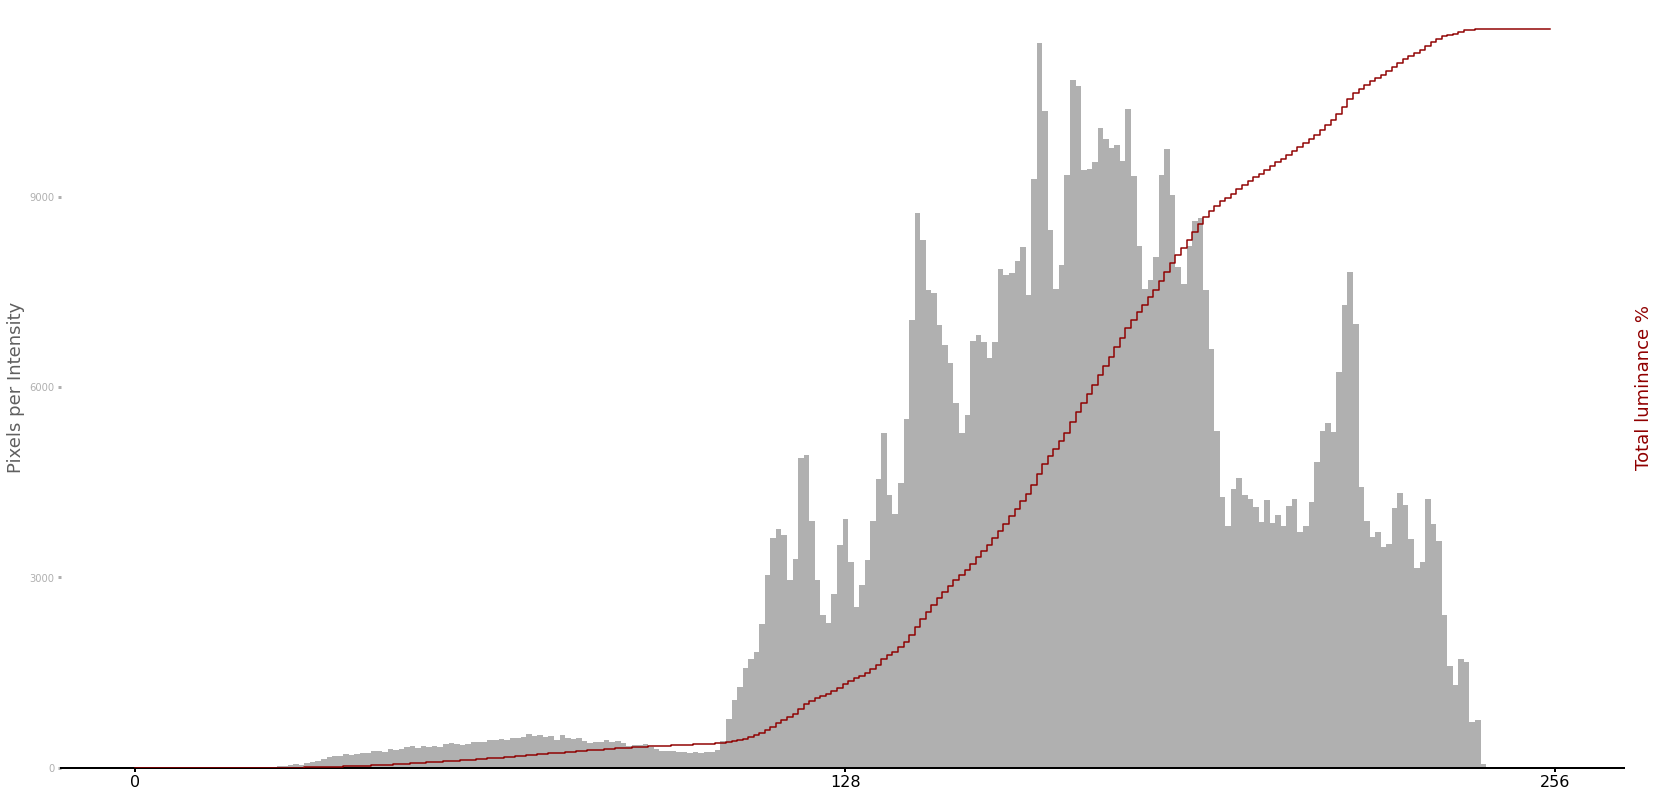

In [0]:
#@markdown **Grayscaled Intensities**

#@markdown Binned by OpenCV, plotted by `matplotlib`

#@markdown [Stale y axis]
#%%time

fig, ax1 = plt.subplots(figsize=(28, 14)) #, constrained_layout=True)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# specify we want a second glyph to share the same x-axis
ax2 = ax1.twinx() # This is the code to get two subplots sharing the same X axis

# Turn off border except bottom
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_visible(False)
#ax1.spines['left'].set_color(hist_color)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax2.spines['left'].set_color(hist_color)

# Histogram as bars
_ = ax1.bar(eight_bit_range, intensities_dist_by_cv2.ravel(), width=1.0, color=hist_color)#, ec='r')#, 'b')
# line plot works: _ = ax1.plot(intensities, color=hist_color)
#ax1.set_title('Pixels by Intensity', fontsize=20, fontdict={'fontweight': 'bold'})
#ax1.xaxis.set_major_locator(plt.MultipleLocator(128))
ax1.set_xticks([0, 128, 256])
ax1.tick_params(axis='x', bottom=True, width=2, color='k', labelsize=16)
ax1.set_ylabel('Pixels per Intensity', color=hist_color, fontsize=18)
ax1.yaxis.label.set_color('#606060') #hist_color)
ax1.tick_params(axis='y', color=hist_color, width=3, labelcolor=hist_color) #color='#0b559f')
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

# Cummulative histogram as line
_ = ax2.step(eight_bit_range, intensities_cdf_by_cv2, color=cdf_color, where='mid')
ax2.set_ylim(0,np.max(intensities_cdf_by_cv2) * 1.03)
ax2.tick_params(axis='y', right=False, color=cdf_color)
ax2.set_yticklabels([])
_ = ax2.set_ylabel('Total luminance %', fontsize=18, color=cdf_color)

Flat versus ravel()?